# Airbnb Rio de Janeiro - XGBoost

# 1. Introdução

Esse notebook propõe aplicar um modelo XGBoost para os [dados do Airbnb na cidade do Rio de Janeiro](https://insideairbnb.com/get-the-data/#:~:text=Rio%20de%20Janeiro%2C%20Rio%20de%20Janeiro%2C%20Brazil). 

Os dados são carregados do processo de [feature engineering](https://github.com/BPRateiro/rio-airbnb-data-analysis/blob/main/notebooks/feature_engineering.ipynb).Incluem informações detalhadas sobre a disponibilidade de listagens, características dos imóveis, interações de usuários, e preços. 

O objetivo principal é construir um modelo com as melhores métricas possíveis.

## 1.1 Configurações e bibliotecas

In [1]:
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import pandas as pd
import shap
shap.initjs()

import sys
import os
sys.path.append(os.path.abspath('..'))

from rio_airbnb.modeling.train import BayesianXGBoostOptimizer
from rio_airbnb.modeling.predict import load_mais_recente, print_model_metrics
from rio_airbnb.plots import ShapPlotter, plot_feature_importance

2024-10-15 16:31:01.509 | INFO     | rio_airbnb.config:<module>:11 - PROJ_ROOT path is: C:\Bruno\Projects\rio-airbnb-data-analysis


## 1.2 Leitura dos dados

In [2]:
df_train = pd.read_parquet('../data/silver/fe_train_output.parquet')
df_test = pd.read_parquet('../data/silver/fe_test_output.parquet')

df_train.drop(columns=[col for col in df_train.columns if df_train[col].nunique() == 1], inplace=True)
df_train.head()

,accommodates,availability_365,availability_60,bathrooms,bedrooms,beds,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,days_since_first_review,...,review_scores_value,reviews_per_month,verification_email,verification_work_email,was_reviewed,host_response_time_within_a_day,host_response_time_within_a_few_hours,host_response_time_within_an_hour,room_type_others,room_type_private_room
0,5.0,269.0,59.0,2.0,1.0,2.0,1.0,0.0,0.0,131.8,...,4.502,1.700,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.0,176.0,56.0,2.0,2.0,0.0,6.0,0.0,0.0,173.0,...,4.500,0.690,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,2.0,267.0,59.0,1.0,1.0,1.0,0.0,2.0,0.0,151.4,...,4.600,0.448,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,2.0,38.0,35.0,1.0,1.0,1.0,1.0,1.0,0.0,531.0,...,5.000,0.230,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,5.0,10.0,10.0,2.0,2.0,3.0,1.0,0.0,0.0,3631.0,...,4.740,3.040,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


# 2. Modelo de baseline

In [3]:
# Separando as variáveis independentes e dependentes
X_train = df_train.drop(columns=['price'])
X_test = df_test.drop(columns=['price'])
y_train = df_train['price']
y_test = df_test['price']

modelo_baseline = XGBRegressor()
modelo_baseline.fit(X_train, y_train)
y_pred = modelo_baseline.predict(X_test)

# Avaliar o desempenho com diversas métricas
print_model_metrics(modelo_baseline, X_test, y_test)

[MSE] Mean Squared Error do modelo baseline:  23408.134020892307
[RMSE] Root Mean Squared Error do modelo baseline:  152.99716997674273
[MAE] Mean Absolute Error do modelo baseline:  106.73916695198423
[MAPE] Mean Absolute Percentage Error do modelo baseline:  0.3588437232554324
[R2] R2 Score do modelo baseline:  0.588254088377984


# 3. Modelo otimizado

Utilizaremos o espaço de busca proposto em [Analytics Vidhya - XGBoost Parameters Tuning: A Complete Guide with Python Codes](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/). Mas ao invés de fazer sucessivos passos de `GridSearch`, utilizaremos um único passo com `BayesSearchCV` com o mesmo espaço de busca.

- `n_estimators` (50 a 500): Controla o número de árvores no modelo XGBoost.
- `max_depth` (3 a 10): Define a profundidade máxima de cada árvore, impactando a capacidade do modelo de capturar padrões complexos.
- `min_child_weight` (1 a 6): Especifica o peso mínimo de uma folha, ajudando a controlar o overfitting.
- `gamma` (0 a 0.5): Controla a penalização para divisão de nós, favorecendo divisões mais conservadoras.
- `subsample` (0.6 a 0.9): Define a fração de amostras usadas em cada árvore, reduzindo a correlação entre árvores.
- `colsample_bytree` (0.6 a 0.9): Define a fração de features usadas em cada árvore para reduzir a correlação entre árvores.
- `reg_alpha` (1e-5 a 100, log-uniform): Coeficiente de regularização L1, que incentiva a criação de modelos mais esparsos e ajuda a reduzir o overfitting.

In [4]:
otimizador = BayesianXGBoostOptimizer(n_iter=50, random_state=75)
otimizador.fit(X_train, y_train)

2024-10-15 16:31:13.165 | INFO     | rio_airbnb.modeling.train:fit:151 - Iniciando o processo de ajuste do modelo...
2024-10-15 16:48:42.147 | INFO     | rio_airbnb.modeling.train:fit:154 - Ajuste do modelo concluído.
2024-10-15 16:48:42.219 | INFO     | rio_airbnb.modeling.train:_save_model:128 - Modelo salvo em: C:\Bruno\Projects\rio-airbnb-data-analysis\models\xgb_model_20241015_164842.pkl


In [5]:
modelo_otimizado = load_mais_recente(model_prefix="xgb_model")
print_model_metrics(modelo_otimizado, X_test, y_test)

2024-10-15 16:48:42.343 | INFO     | rio_airbnb.modeling.predict:load_mais_recente:28 - Modelo mais recente carregado: C:\Bruno\Projects\rio-airbnb-data-analysis\models\xgb_model_20241015_164842.pkl
2024-10-15 16:48:42.359 | INFO     | rio_airbnb.modeling.predict:load_mais_recente:32 - O modelo é uma instância de BayesSearchCV, retornando best_estimator_
[MSE] Mean Squared Error do modelo baseline:  21854.287002819798
[RMSE] Root Mean Squared Error do modelo baseline:  147.83195528308417
[MAE] Mean Absolute Error do modelo baseline:  102.28683063133437
[MAPE] Mean Absolute Percentage Error do modelo baseline:  0.3411095060583907
[R2] R2 Score do modelo baseline:  0.615586047277672


# 4. Interpretação dos resultados

## 4.1 Feature Importance

O gráfico abaixo mostra que o número de quartos é a feature mais importante do modelo. Geralmente o número de quartos é um fator determinante no preço de uma propriedade. Se o anfitrião em seguida pode estar relacionado à experiência do usuário e à confiabilidade do locatário. Da mesma forma que o número de quartos, o número de banheiros também é importante ao preço.

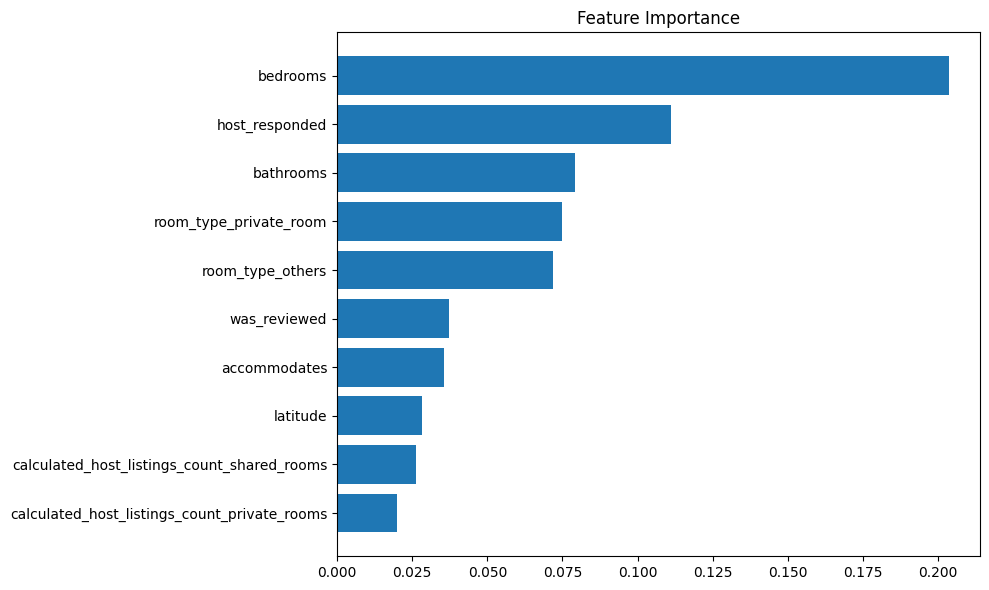

In [6]:
plot_feature_importance(modelo_otimizado, X_train.columns, max_num_features=10)

## 4.2 Dependência parcial

Instanciaremos uma classe `ShapPlotter` com nosso modelo otimizado e os dados. A classe calcula os valores SHAP para as amostras do teste que serão usados para media a contribuição individual de cada variável no resultado final das previsões do modelo.

In [7]:
shap_plotter = ShapPlotter(modelo_otimizado, X_train, X_test)

100%|===================| 6026/6044 [02:21<00:00]        

Cada ponto no gráfico representa uma observação do dado. Para número de quartos de 1 à 5, à medida que o número de quartos aumenta, maior o impacto nas previsões do modelo. Em acomodações com mais de 5 quartos, o impacto dessa variável tende a diminuir.

Para uma dado número de quartos, quanto maior o número de pessoas que ele pode acomodar, maior é o impacto positivo no modelo.

Essa relação não é linear e após 5 quartos, o impacto da variável `bedrooms` começa a diminuir.

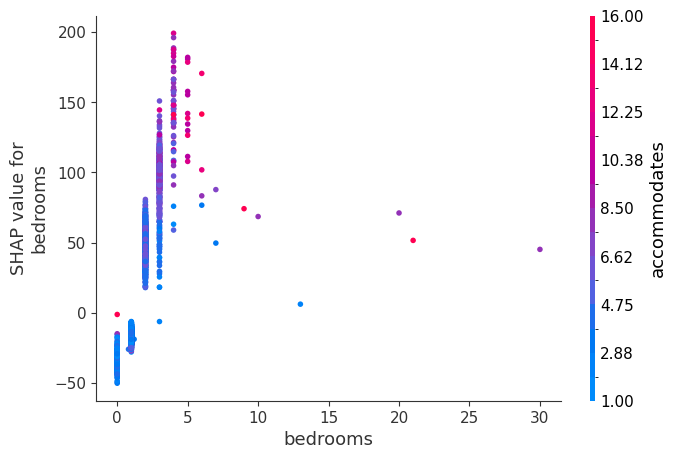

In [8]:
shap_plotter.plot_dependence('bedrooms', 'accommodates')

## 4.3 Beeswarm plot

- `latitude`: Valores mais altos de latitude tendem a diminuir a previsão do modelo, enquanto valores mais baixos têm um impacto positivo, sugerindo que imóveis localizados mais ao sul tendem a ser mais valorizados.
- `longitude`: Valores mais altos de longitude tendem a aumentar a previsão, enquanto valores mais baixos diminuem, sugerindo que imóveis localizados mais à leste  tendem a ser mais valorizados.
- `bedrooms`: O número de quartos impacta o modelo de forma previsível. Mais quartos aumentam o preço do imóvel. O que é esperado, já que mais quartos geralmente aumentam o valor de uma propriedade.
- `days_since_last_review`: Quanto mais recente a avaliação, menor o preço. Sugere que imóveis com preço mais baixo tendem a ter reviews mais frequentemente.
- `bathrooms`: Assim como os quartos, mais banheiros tendem a aumentar o preço. 
- `accommodates`: O preço aumenta conforme o número da capacidade de acomodação aumenta. Isso é intuitivo, já que imóveis maiores geralmente têm preços mais altos.
- `host_responded`: Indica se ouve resposta do host. Quando o host responde, o preço tende a cair, o que pode indicar negociação com o cliente.
- `reviews_per_month`: Quanto maior o número de avaliações por mês, menor o impacto positivo no modelo. Isso indica que imóveis com avaliações frequentes são mais baratos.
- `room_type_private_room`: Quarto privados tende a diminuir a previsão relativo à outros tipos de quartos.
- `number_of_reviews`: Um maior número de avaliações tem um impacto negativo no modelo. Isso pode sugerir uma maior rotatividade devido aos preços acessíveis

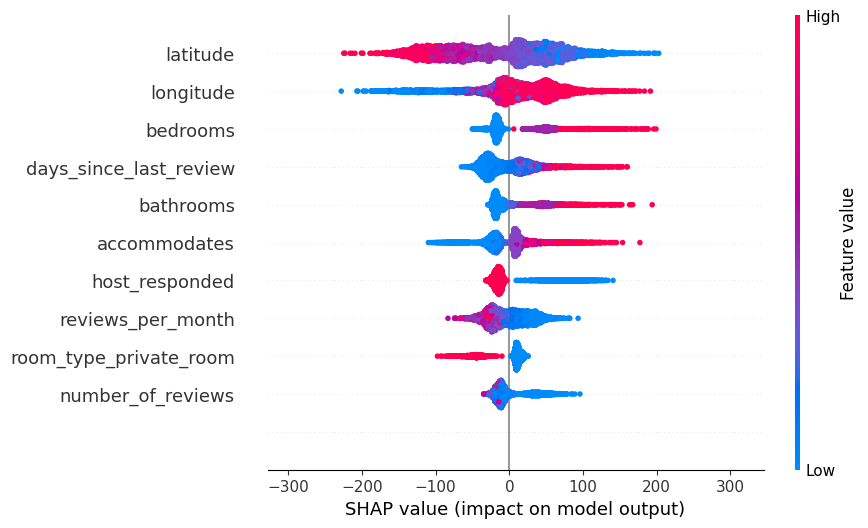

In [9]:
shap_plotter.plot_beeswarm(max_display=11)

## 4.4 Simulações

Os dados simulados foram gerados a partir de um dataset de treino. Todas as variáveis foram escolhidas aleatoriamente dentro do intervalo de cada variável.
Exceto as coordenadas de latitudes e longitudes onde foram fixados os bairros **Barra da Tijuca**, **Barra Olímpica** e **Andaraí**.

O gráfico apresenta os impactos de várias características sobre a previsão do preço simulado médio de R$ 358.58. Barras vermelhas representam características que aumentaram a previsão do modelo, enquanto azuis indicam que diminuíram a previsão.

In [10]:
df_simulated = pd.read_csv('../data/external/simulated_data.csv')
shap_simulated = ShapPlotter(modelo_otimizado, X_train, df_simulated.drop(columns=['price']))
df_simulated.head()

,accommodates,availability_365,availability_60,bathrooms,bedrooms,beds,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,days_since_first_review,...,verification_email,verification_work_email,was_reviewed,host_response_time_within_a_day,host_response_time_within_a_few_hours,host_response_time_within_an_hour,room_type_others,room_type_private_room,latitude,longitude
0,8.0,45.0,22.0,2.0,2.0,1.0,1.0,0.0,0.0,183.2,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-23.0005,-43.3659
1,4.0,227.0,59.0,2.0,1.0,1.0,5.0,0.0,0.0,219.0,...,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,-22.9751,-43.4064
2,6.0,145.0,59.0,1.0,1.0,6.0,2.0,0.0,0.0,1766.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-22.9269,-43.2587


### 4.4.1 Barra da Tijuca

O preço simulado do imóvel da Barra da Tijuca é de 529.44. Esse valor é R$ 170.86 acima da média.

- **`maximum_nights` (365, -195.86)**: Maior impacto negativo. Ter um limite alto para o número máximo de noites parece diminuir significativamente o preço previsto.
- **`minimum_nights` (4, +146.32)**: O valor mínimo de 4 noites contribuiu para aumentar o preço previsto.
- **`accommodates` (8, +86.02)**: A capacidade de acomodar até 8 pessoas também influenciou positivamente, aumentando o valor do preço previsto.
- **`neighborhood_overview_length` (0, +81.08)**: Apesar de o comprimento do resumo do bairro ser zero, isso aumentou o preço previsto, sugerindo um comportamento específico do modelo.
- **`num_amenities` (31, -50.03)**: O número de amenidades, embora alto, teve um impacto negativo no preço previsto, talvez devido a uma correlação específica com essa variável.
- **`verification_work_email` (0, +48.29)**: A ausência de um e-mail de verificação de trabalho aumentou o preço, indicando que essa verificação não é essencial para aumentar o valor previsto.
- **`days_since_last_review` (4, -39.67)**: O fato de haver apenas 4 dias desde a última avaliação reduziu o preço previsto, possivelmente indicando que avaliações muito recentes podem ter um impacto negativo.
- **`bedrooms` (2, +32.13)**: O número de quartos teve um impacto positivo, o que é esperado, pois mais quartos geralmente aumentam o valor de uma propriedade.
- **`verification_email` (0, +30.27)**: A ausência de verificação de e-mail contribuiu para aumentar o preço previsto.
- **`34 outras características` (+32.33)**: O conjunto de outras 34 características também contribuiu ligeiramente para o aumento do preço previsto.

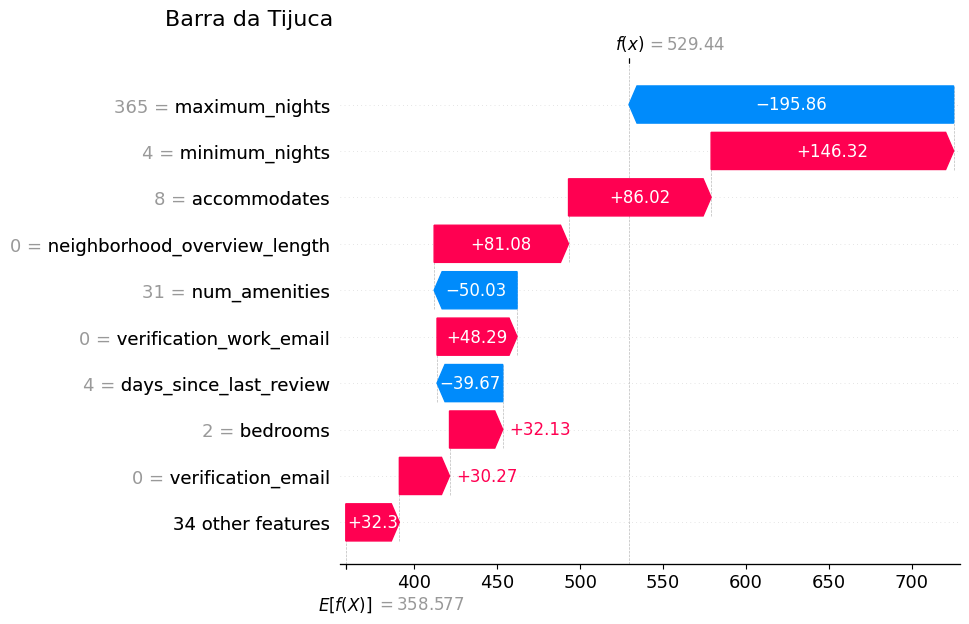

In [11]:
shap.plots.waterfall(shap_simulated.explanation[0], show=False)
plt.title("Barra da Tijuca", fontsize=16, loc='right', x=-0.01)
plt.show()

### 4.4.2 Barra Olímpica

O preço simulado do imóvel da Barra Olímpica é de 316.99. Esse valor é R$ 41.58 abaixo da média.

- **`maximum_nights` (800, -231.65)**: Maior impacto negativo. Ter um limite alto para o número máximo de noites reduz drasticamente o preço previsto.
- **`minimum_nights` (1, +136.96)**: O valor mínimo de 1 noite teve um impacto positivo substancial, aumentando o valor do preço previsto.
- **`verification_work_email` (0, +38.34)**: A ausência de um e-mail de verificação de trabalho aumentou o preço previsto.
- **`review_scores_accuracy` (5, -36.22)**: Uma pontuação alta de precisão nas avaliações diminuiu o preço previsto, o que pode sugerir uma correlação inesperada neste modelo.
- **`bathrooms` (2, +35.96)**: O número de banheiros teve um impacto positivo no preço previsto.
- **`num_amenities` (15, -34.05)**: O número de amenidades teve um impacto negativo, o que pode refletir uma correlação específica com esta variável no modelo.
- **`host_response_time_within_a_few_hours` (0, +31.8)**: A resposta do anfitrião em poucas horas aumentou o preço previsto.
- **`verification_email` (1, +31.79)**: A presença de verificação de e-mail aumentou o valor do preço previsto.
- **`host_responded` (1, -24.47)**: A resposta do anfitrião contribuiu negativamente para o preço, reduzindo o valor.
- **`34 outras características` (+9.96)**: O conjunto de outras 34 características também contribuiu ligeiramente para aumentar o preço previsto.

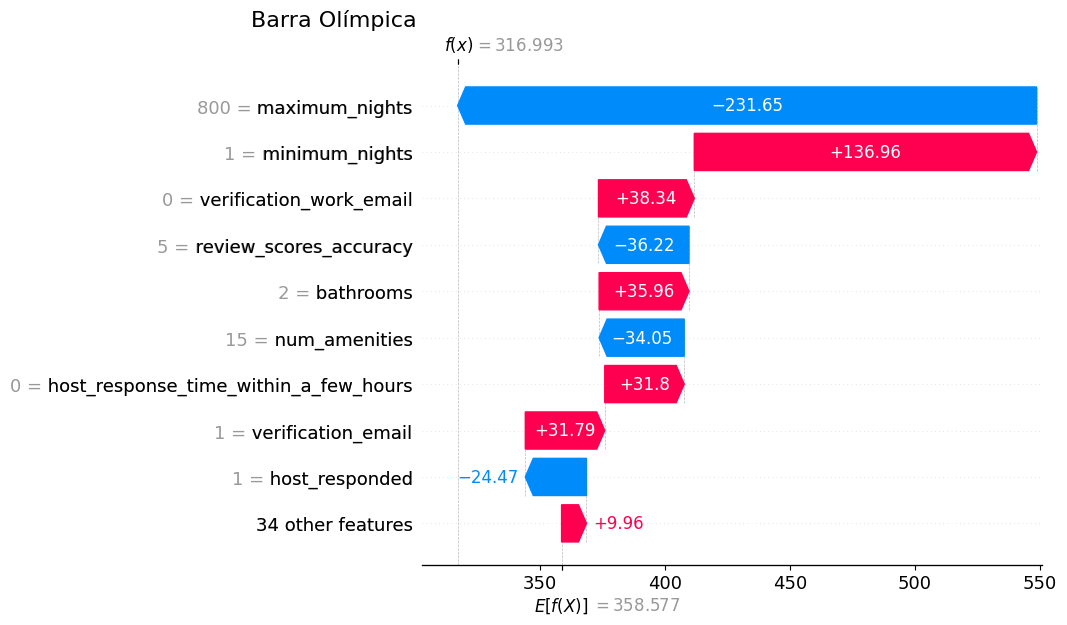

In [12]:
shap.plots.waterfall(shap_simulated.explanation[1], show=False)
plt.title("Barra Olímpica", fontsize=16, loc='right', x=-0.01)
plt.show()

### 4.4.3 Andaraí

O preço simulado do imóvel de Andaraí é de 385.17. Esse valor é R$ 26.60 acima da média.

- **`minimum_nights` (2, +156.26)**: O valor mínimo de 2 noites foi o maior impacto positivo, aumentando significativamente o valor do preço previsto.
- **`maximum_nights` (60, -136.16)**: Um limite relativamente baixo de noites máximas teve um impacto negativo considerável, reduzindo o preço previsto.
- **`num_amenities` (55, -67.97)**: O alto número de amenidades diminuiu o valor previsto, sugerindo uma possível correlação negativa no modelo.
- **`neighborhood_overview_length` (0, +66.88)**: O tamanho zero do resumo do bairro contribuiu positivamente, aumentando o preço.
- **`verification_work_email` (0, +38.63)**: A ausência de um e-mail de verificação de trabalho aumentou o preço previsto.
- **`accommodates` (6, +36.3)**: A capacidade de acomodar 6 pessoas influenciou positivamente, aumentando o preço.
- **`verification_email` (1, +34)**: A verificação de e-mail contribuiu de forma positiva para o aumento do valor.
- **`reviews_per_month` (1.616, -28.95)**: O número médio de avaliações por mês teve um impacto negativo, reduzindo o preço previsto.
- **`review_scores_rating` (4.21, +26.72)**: A boa pontuação de avaliação aumentou o valor previsto.
- **`34 outras características` (-99.1)**: O conjunto de outras 34 características reduziu o valor do preço previsto, sugerindo um impacto agregado negativo.

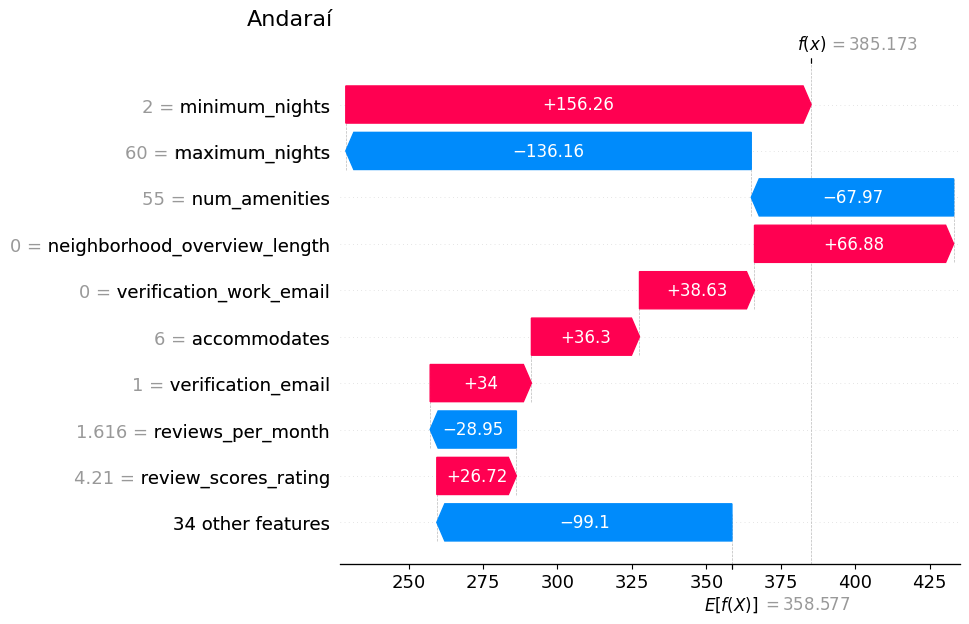

In [13]:
shap.plots.waterfall(shap_simulated.explanation[2], show=False)
plt.title("Andaraí", fontsize=16, loc='right', x=-0.01)
plt.show()

# 5. Conclusão

O modelo XGBoost apresentou uma métrica R² melhor que o modelo de regressão gama. Portanto, esse modelo é capaz de explicar melhor a variabilidade dos dados.

Utilizamos o modelo para prever o preço de aluguéis em diferentes bairros para dados simulados, com foco em explicar as previsões usando valores SHAP. Notamos que as variáveis que eram importantes para o modelo de regressão gama não necessariamente são as mais importantes para esse modelo.